In [24]:
from config import BASE_DIR
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
BASELINE_DIR = f"{BASE_DIR}/reports/baselines"
EXP_GNN_DIR = f"{BASE_DIR}/reports/gnn/gcn_bert_ensemble"



In [27]:
import os
def list_files(dir):
    filenames = []
    for root, dirs, files in os.walk(dir):
        for file in files:
            filenames.append(file)
    return filenames
print(list_files(BASELINE_DIR))


['composition_unsupervised.csv', 'section_supervised.csv', 'section_unsupervised.csv', 'book_unsupervised.csv', 'composition_supervised.csv', 'book_supervised.csv']


In [29]:
pd.read_csv(f'{BASELINE_DIR}/section_unsupervised.csv')

,Unnamed: 0,vectorizer_type,ari,jaccard,dasgupta
0,6,yonatanlou/BEREL-finetuned-DSS-composition-cla...,-0.056186,0.212871,0.800978
1,5,yonatanlou/BEREL-finetuned-DSS-sectarian-class...,0.607764,0.032910,0.726306
2,7,yonatanlou/BEREL-finetuned-DSS-maskedLM,-0.001501,0.335607,0.721200
3,4,dicta-il/dictabert,0.018060,0.352066,0.689124
4,1,onlplab/alephbert-base,0.023825,0.362668,0.674781
5,0,dicta-il/BEREL,-0.003966,0.230125,0.660578
6,8,tfidf,0.092711,0.296393,0.642042
7,9,trigram,-0.005977,0.289120,0.631340
8,3,dicta-il/dictabert-large,-0.012226,0.201889,0.610510
9,2,dicta-il/dictabert-tiny,-0.019330,0.182370,0.587870


In [26]:
tasks = ["composition","section"]
gnn_name_fomrat = "gcn_bert_ensemble_{}_100_words_3_adj_types.csv"

compare_list = {"book": [f"{BASELINE_DIR}/book_supervised.csv", f"{EXP_GNN_DIR}/{gnn_name_fomrat.format('book')}"],
                "composition": [f"{BASELINE_DIR}/composition_supervised.csv", f"{EXP_GNN_DIR}/{gnn_name_fomrat.format('composition')}"],
                "section": [f"{BASELINE_DIR}/section_supervised.csv", f"{EXP_GNN_DIR}/{gnn_name_fomrat.format('section')}"]}

In [4]:

COMPARISON_SCHEME = ["task","model", "vectorizer",  "test_acc", "weighted_f1", "micro_f1", "macro_f1", "adj_type"]

In [5]:

results = []
for task in tasks:
    
    baseline = pd.read_csv(compare_list[task][0])
    baseline = baseline.rename(columns={"accuracy":"test_acc"})
    baseline=baseline[baseline["model"].isin(["LogisticRegression","MLPClassifier"])]
    baseline = baseline.sort_values(by="test_acc",ascending=False)
    baseline["task"] = task
    baseline["adj_type"] = None
    results.append(baseline[COMPARISON_SCHEME].to_dict(orient="records"))
    
    
    gnn = pd.read_csv(compare_list[task][1])
    gnn = gnn.rename(columns={"bert_model":"vectorizer"})
    
    
    max_idx = gnn.groupby('vectorizer')['val_acc'].idxmax()
    max_test_acc_rows = gnn.loc[max_idx]
    max_test_acc_rows["model"] = "GCN"
    max_test_acc_rows["task"] = task
    results.append(max_test_acc_rows[COMPARISON_SCHEME].to_dict(orient="records"))

all_results = pd.DataFrame([item for sublist in results for item in sublist])
all_results

,task,model,vectorizer,test_acc,weighted_f1,micro_f1,macro_f1,adj_type
0,composition,MLPClassifier,onlplab/alephbert-base,0.717791,0.714774,0.717791,0.631972,None
1,composition,LogisticRegression,dicta-il/dictabert-large,0.711656,0.696326,0.711656,0.605253,None
2,composition,LogisticRegression,yonatanlou/BEREL-finetuned-DSS-maskedLM,0.711656,0.700188,0.711656,0.593149,None
3,composition,MLPClassifier,yonatanlou/BEREL-finetuned-DSS-maskedLM,0.711656,0.700728,0.711656,0.605181,None
4,composition,MLPClassifier,dicta-il/BEREL,0.705521,0.689711,0.705521,0.588291,None
5,composition,LogisticRegression,dicta-il/BEREL,0.705521,0.692880,0.705521,0.591038,None
6,composition,MLPClassifier,yonatanlou/BEREL-finetuned-DSS-sectarian-class...,0.699387,0.688073,0.699387,0.612305,None
7,composition,MLPClassifier,trigram,0.699387,0.680139,0.699387,0.547130,None
8,composition,LogisticRegression,dicta-il/dictabert,0.699387,0.691956,0.699387,0.600642,None
9,composition,MLPClassifier,dicta-il/dictabert-large,0.693252,0.684362,0.693252,0.593367,None


In [6]:
for task in all_results['task'].unique():
    tmp = all_results[all_results['task']==task].sort_values(by="test_acc", ascending=False).head(20)
    tmp.to_csv(f"{BASE_DIR}/reports/tables/{task}_classification_top_20.csv", index=False)
    

In [7]:

def get_group_by_vectorizer(i):
    if "yonatanlou" in i:
        return 'fine_tuned'
    elif "dicta" in i or "onlplab" in i:
        return 'pre_trained_bert'
    else:
        return 'classic_text_features'
all_results["vectorizer_type"] = all_results["vectorizer"].apply(get_group_by_vectorizer)            



In [8]:

def generate_color_map(df, col, group_name, base_color="PuOr",base_color_by_group=None):
    
    groups = df.groupby(group_name)[col].apply(list).to_dict()
    num_groups = df[col].nunique()
    all_colors = list(sns.color_palette(base_color, num_groups))
    color_map = {}
    i=0
    if not base_color_by_group:
        for group, items in groups.items():
            items = list(set(items))

            for item in items:
                color_map[item] = all_colors[i]
                i+=1
        return color_map
        
    # Function to generate shades of a base color
    def generate_shades(base_color, num_shades):
        # return sns.hls_palette(num_shades, h=base_color, l=0.5, s=0.5)
        
        return sns.color_palette(base_color,n_colors=num_shades+1)
    
    # Create the color map
    color_map = {}
    for group, items in groups.items():
        shades = generate_shades(base_color_by_group[group], len(items))
        for item, shade in zip(items, shades):
            color_map[item] = shade
    return color_map

base_color_by_group = {
    'classic_text_features': "coolwarm",   # Red
    'pre_trained_bert': "viridis",     # Green
    'fine_tuned': "Spectral"            # Blue
}



In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

def generate_bar_plot(all_results, x_col, y_col, hue_col,vectorizer_type_col, color_map, filename,which_hue_cols=False):

    # Create a figure and a set of subplots
    fig, axes = plt.subplots(nrows=len(all_results['task'].unique()), ncols=1, figsize=(12, 6 * len(all_results['task'].unique())), sharey=False)
    all_results['task'] = all_results['task'].replace("section", "sectarian")
    for i, task in enumerate(all_results['task'].unique()):
        # Filter data for the current task
        task_data = all_results[all_results['task'] == task]
        if which_hue_cols is not None:
            task_data = task_data[task_data[hue_col].isin(which_hue_cols)]
        
        sns.barplot(ax=axes[i], x=x_col, y=y_col, hue=hue_col, data=task_data, palette=color_map)
        axes[i].set_title(f'{y_col} by {hue_col} by {x_col} for {task}', fontsize=16)
        
        # Adjusting the y-axis limits
        min_y_col = task_data[y_col].min()
        max_y_col = task_data[y_col].max()
        padding = (max_y_col - min_y_col) * 0.1
        axes[i].set_ylim(min_y_col - padding, max_y_col + padding)
        
        axes[i].set_xlabel('Model', fontsize=14)
        axes[i].set_ylabel(y_col, fontsize=14)
        axes[i].tick_params(axis='x', rotation=45)
        
        # axes[i].get_legend().remove()
        
        # Get handles and labels, then sort them by the vectorizer_type column
        handles, labels = axes[i].get_legend_handles_labels()

        # Create a dataframe for sorting
        legend_df = pd.DataFrame({'label': labels, 'handle': handles})
        legend_df = legend_df.merge(all_results[[hue_col, vectorizer_type_col]].drop_duplicates(), left_on='label', right_on=hue_col)
        legend_df = legend_df.sort_values(by=vectorizer_type_col)
        
        # Extract sorted handles and labels
        sorted_handles = legend_df['handle'].tolist()
        sorted_labels = legend_df['label'].tolist()
        axes[i].legend(sorted_handles, sorted_labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        axes[i].grid(alpha=0.5)

    plt.tight_layout()
    if filename:
        plt.savefig(filename)
    plt.show()
    

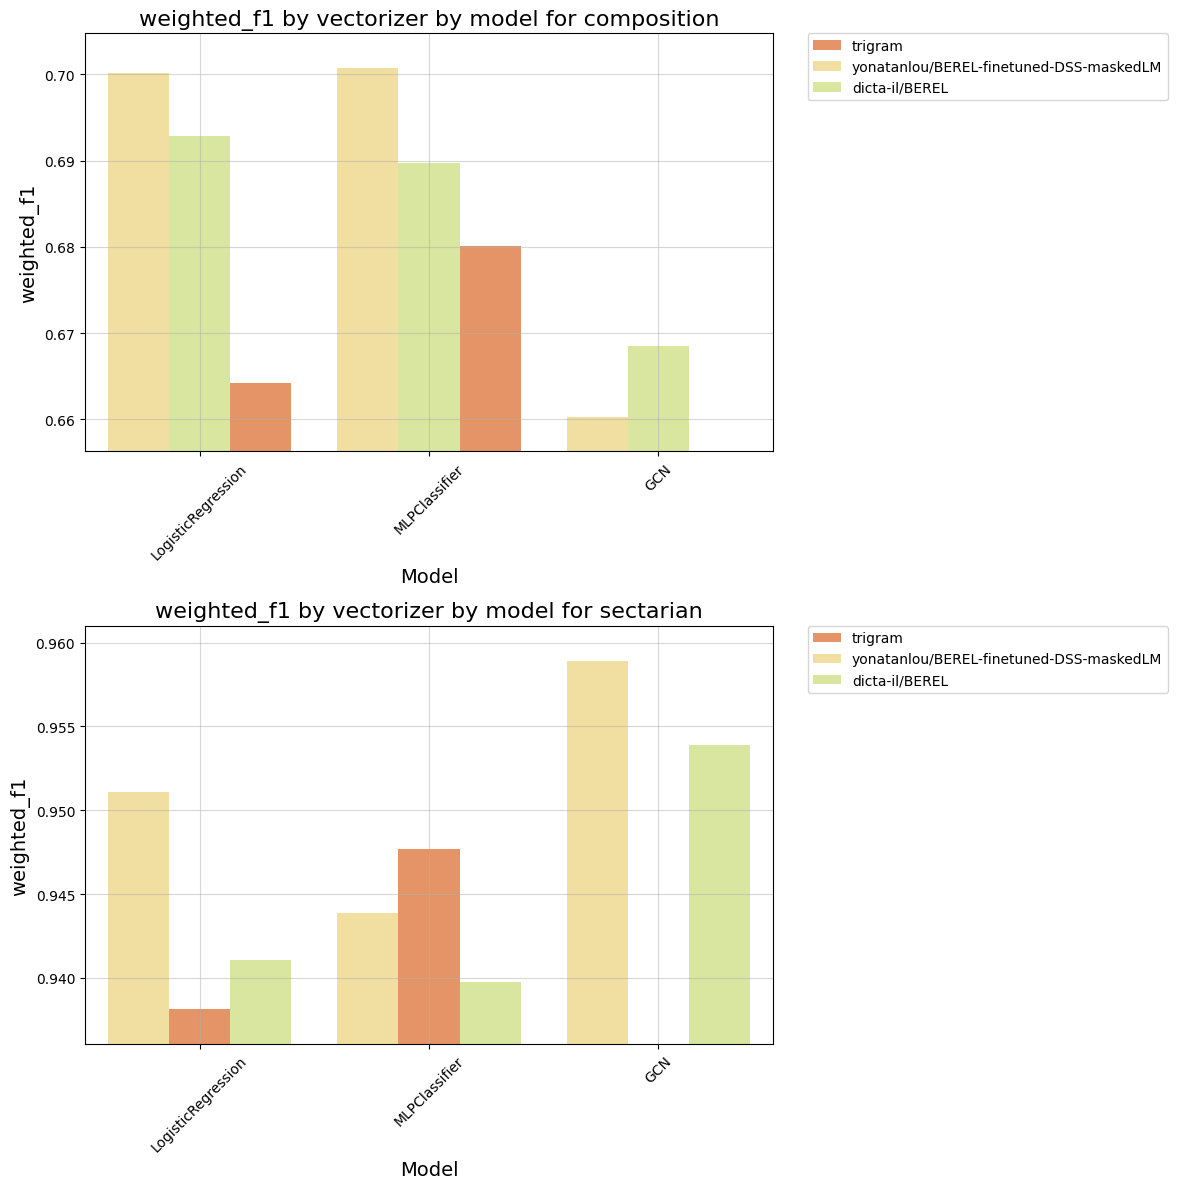

In [10]:

color_map = generate_color_map(all_results, "vectorizer","vectorizer_type","RdYlGn", None)
# file_name = f"{BASE_DIR}/reports/plots/comparison/classification_comparison_composition_sectarian.png"
file_name = None
hue_cols = list(all_results[all_results["model"]=="GCN"]["vectorizer"].unique())+["trigram"]
plot_obj = generate_bar_plot(all_results[all_results['task']!="book"], "model","weighted_f1", "vectorizer","vectorizer_type", color_map, filename=file_name, which_hue_cols=hue_cols)

In [11]:

results_gnn = []
for task in ["section", "composition"]:
   
    
    gnn = pd.read_csv(compare_list[task][1])
    gnn = gnn.rename(columns={"bert_model":"vectorizer"})
    
    
    gnn["model"] = "GCN"
    gnn["task"] = task
    
    results_gnn.append(gnn.to_dict(orient="records"))


all_results_gnn = pd.DataFrame([item for sublist in results_gnn for item in sublist])
all_results_gnn.columns

Index(['epoch', 'train_loss', 'train_acc', 'val_loss', 'val_acc', 'test_loss',
       'test_acc', 'micro_precision', 'micro_recall', 'micro_f1',
       'macro_precision', 'macro_recall', 'macro_f1', 'weighted_precision',
       'weighted_recall', 'weighted_f1', 'num_adjs', 'epochs', 'hidden_dim',
       'distance', 'learning_rate', 'threshold', 'vectorizer', 'adj_type',
       'num_edges', 'model', 'task'],
      dtype='object')

In [21]:
def make_adj_cat(row):
    
    adj_type = row["adj_type"]
    adj_type_list = str(adj_type).split("& ")
    
    has_bert = any(item.startswith("bert") for item in adj_type_list)
    has_classic = any(not item.startswith("bert") for item in adj_type_list)
    # print(adj_type)
    # print(adj_type_list)
    # print(has_bert)
    # print(has_classic)
    # print()
    if has_bert and not has_classic:
        return "bert" if len(adj_type_list) == 1 else "ensemble-bert"
    elif not has_bert and has_classic:
        return "classic"
    elif has_bert and has_classic:
        return "bert,classic"

all_results_gnn["adj_cat"] = all_results_gnn.apply(make_adj_cat,axis=1)
all_results_gnn

,epoch,train_loss,train_acc,val_loss,val_acc,test_loss,test_acc,micro_precision,micro_recall,micro_f1,...,hidden_dim,distance,learning_rate,threshold,vectorizer,adj_type,num_edges,model,task,adj_cat
0,161,0.054767,0.974152,0.136237,0.956522,0.153922,0.971098,0.971098,0.971098,0.971098,...,300,cosine,0.001,0.99,dicta-il/BEREL,tfidf,7415,GCN,section,classic
1,191,0.065169,0.978998,0.118401,0.971014,0.204945,0.971098,0.971098,0.971098,0.971098,...,300,cosine,0.001,0.98,yonatanlou/BEREL-finetuned-DSS-maskedLM,trigram & bert-alephbert & bert-finetune-lm,14827,GCN,section,"bert,classic"
2,175,0.064087,0.975767,0.099888,0.971014,0.216343,0.965318,0.965318,0.965318,0.965318,...,300,cosine,0.001,0.98,dicta-il/BEREL,tfidf & bert-alephbert & bert-finetune-lm,14827,GCN,section,"bert,classic"
3,184,0.032602,0.988691,0.072231,0.956522,0.208701,0.965318,0.965318,0.965318,0.965318,...,300,cosine,0.001,0.99,yonatanlou/BEREL-finetuned-DSS-maskedLM,BOW-n_gram & bert-alephbert & bert-finetune-lm,7415,GCN,section,"bert,classic"
4,137,0.051315,0.985460,0.084170,0.956522,0.176123,0.965318,0.965318,0.965318,0.965318,...,300,cosine,0.001,0.99,yonatanlou/BEREL-finetuned-DSS-maskedLM,tfidf & trigram & bert-finetune-lm,7415,GCN,section,"bert,classic"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,222,0.320204,0.904110,0.684268,0.815385,0.998107,0.674847,0.674847,0.674847,0.674847,...,300,cosine,0.001,0.98,yonatanlou/BEREL-finetuned-DSS-maskedLM,tfidf,13188,GCN,composition,classic
324,125,0.506697,0.851027,0.947804,0.707692,1.175580,0.650307,0.650307,0.650307,0.650307,...,300,cosine,0.001,0.98,yonatanlou/BEREL-finetuned-DSS-maskedLM,BOW-n_gram,13190,GCN,composition,classic
325,109,0.509829,0.854452,1.071185,0.676923,1.298120,0.650307,0.650307,0.650307,0.650307,...,300,cosine,0.001,0.98,dicta-il/BEREL,BOW-n_gram,13190,GCN,composition,classic
326,104,0.525972,0.844178,1.092664,0.661538,1.297604,0.638037,0.638037,0.638037,0.638037,...,300,cosine,0.001,0.98,dicta-il/BEREL,tfidf & BOW-n_gram,13188,GCN,composition,classic


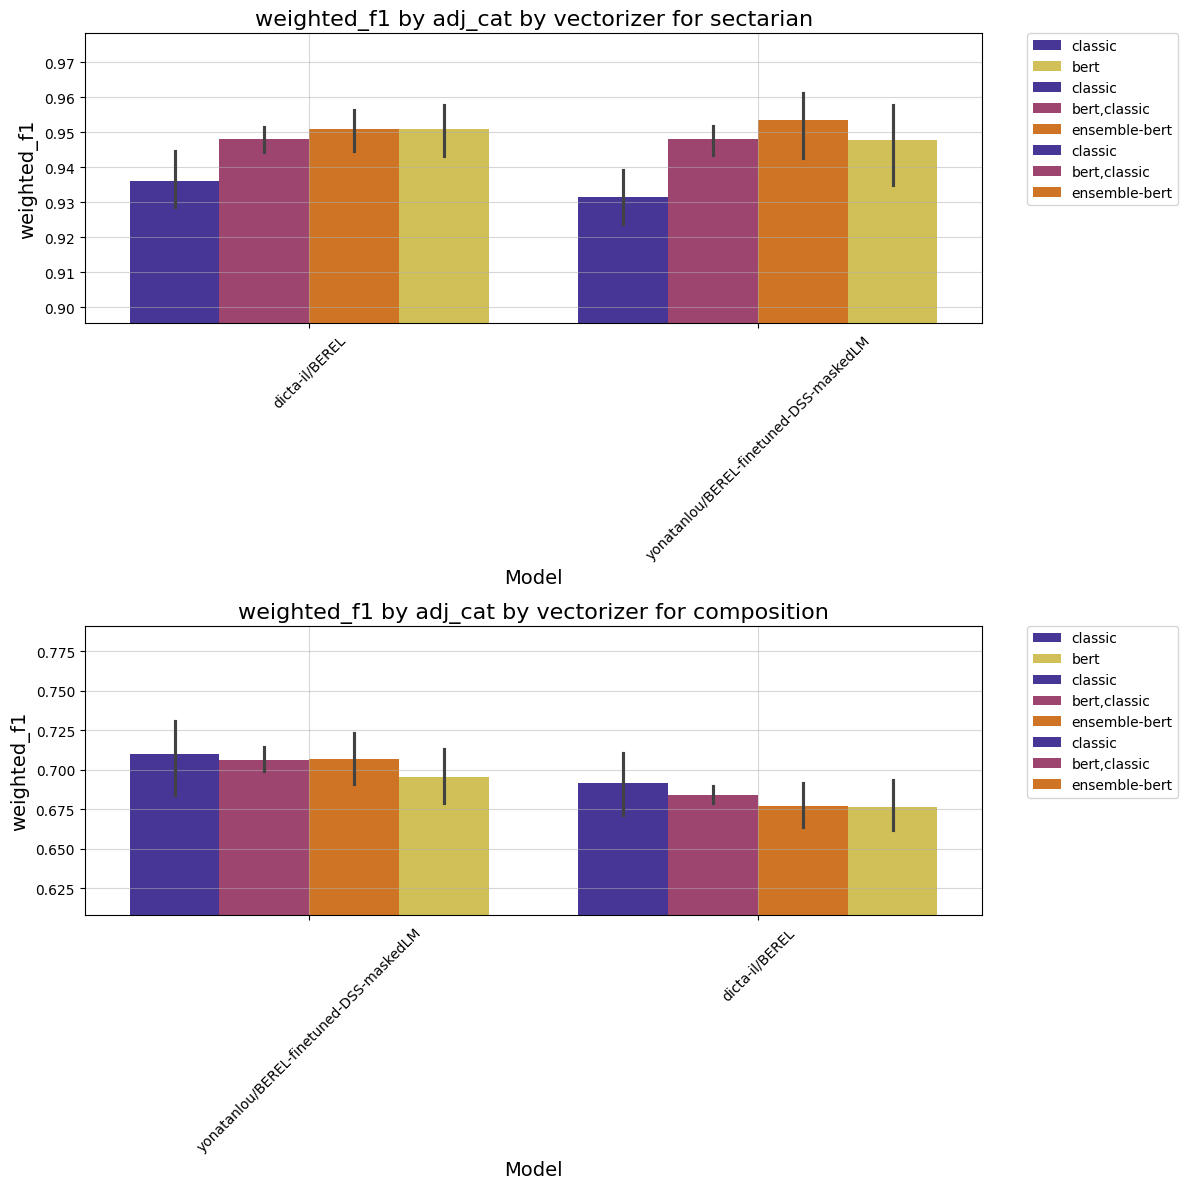

In [22]:
adj_types = all_results_gnn['adj_cat'].unique()
palette = sns.color_palette("CMRmap", len(adj_types))
color_dict = dict(zip(adj_types, palette))
generate_bar_plot(all_results_gnn[all_results_gnn['task']!="book"], "vectorizer","weighted_f1", "adj_cat", "num_adjs",color_dict, filename = None,which_hue_cols=None)

ValueError: The palette dictionary is missing keys: {'tfidf & BOW-n_gram', 'tfidf & trigram', 'trigram & BOW-n_gram', 'trigram', 'tfidf & trigram & BOW-n_gram', 'BOW-n_gram'}

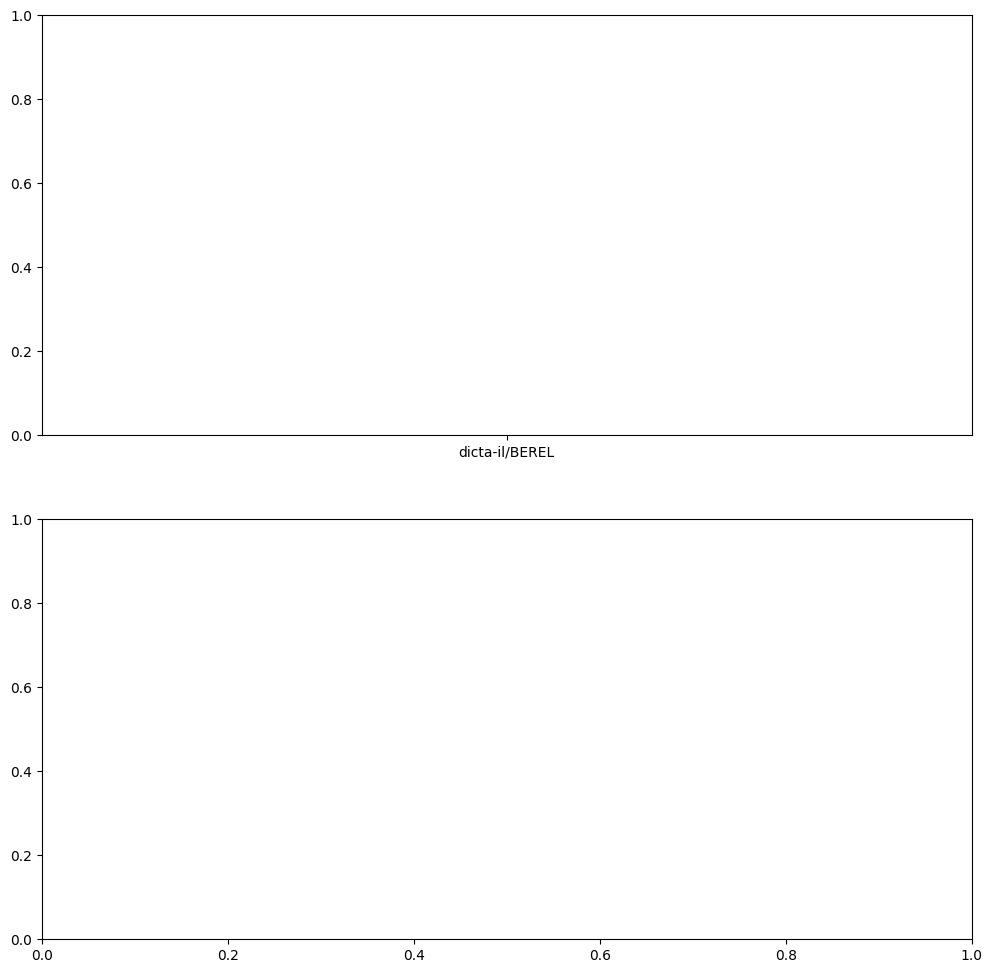

In [13]:
which_hue_cols = ['trigram',
 'tfidf & trigram',
 'tfidf',
 'tfidf & trigram & BOW-n_gram',
 'trigram & BOW-n_gram',
 'BOW-n_gram',
 'tfidf & BOW-n_gram']
palette = sns.color_palette("CMRmap", len(which_hue_cols))
color_dict = dict(zip(adj_types, palette))
generate_bar_plot(all_results_gnn[all_results_gnn['task']!="book"], "vectorizer","weighted_f1", "adj_type", "num_adjs",color_dict, filename = None,which_hue_cols=which_hue_cols)

/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_87437/1835824148.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["number_of_adj_mat"] =tmp["adj_type"].str.split("&").str.len()


Text(0.5, 1.0, 'Number of different edge types with test accuracy (Compostion classification)')

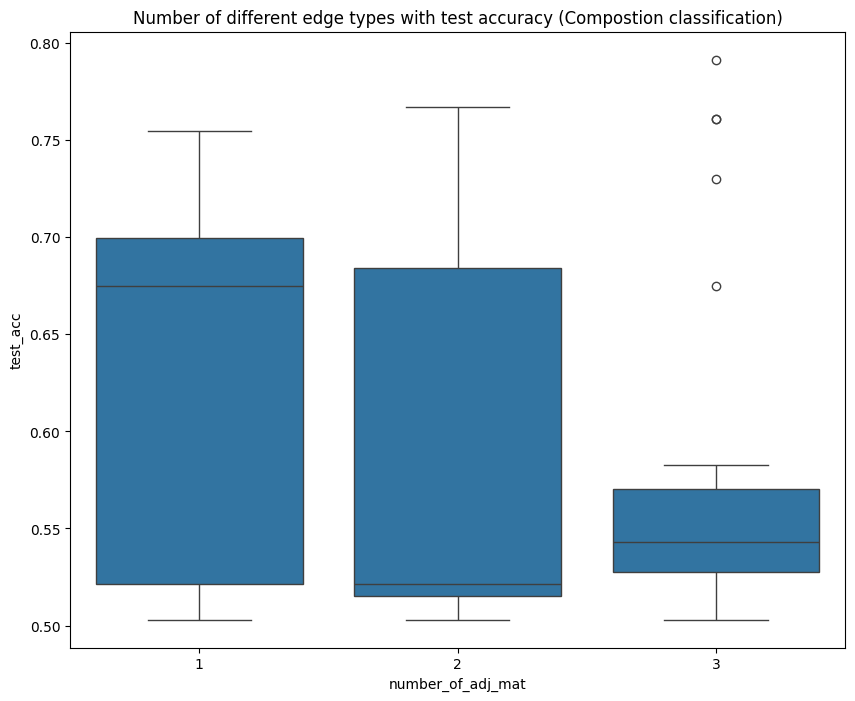

In [13]:
fig= plt.figure(figsize=(10,8))
tmp = all_results_gnn[all_results_gnn['task']=="composition"]

tmp["number_of_adj_mat"] =tmp["adj_type"].str.split("&").str.len()
sns.boxplot(data=tmp, x="number_of_adj_mat", y="test_acc")
plt.title("Number of different edge types with test accuracy (Compostion classification)")

Text(0.5, 1.0, 'Number of different edge types with test accuracy')

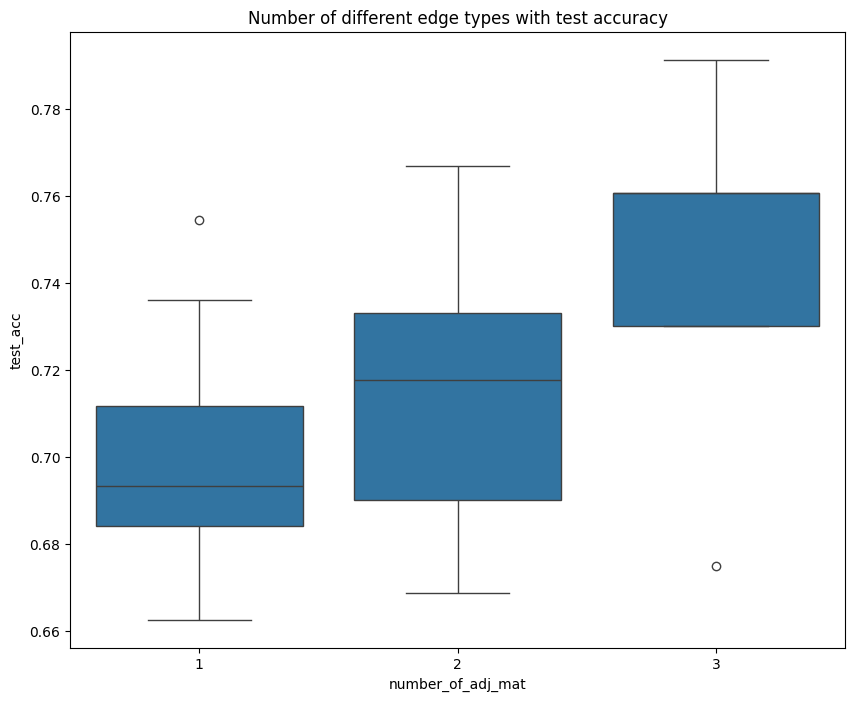

In [17]:
fig= plt.figure(figsize=(10,8))
tmp = all_results_gnn[all_results_gnn['task']=="composition"]
tmp=tmp[(~tmp["adj_type"].str.contains("starr"))]
tmp = tmp[(~tmp["adj_type"].str.contains("topic"))]

tmp["number_of_adj_mat"] =tmp["adj_type"].str.split("&").str.len()
sns.boxplot(data=tmp, x="number_of_adj_mat", y="test_acc")
plt.title("Number of different edge types with test accuracy (Compostion classification)(removing topic modeling and starr)")

/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_87437/3124367501.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["number_of_adj_mat"] =tmp["adj_type"].str.split("&").str.len()


Text(0.5, 1.0, 'Number of different edge types with test accuracy (Sectarian classification)')

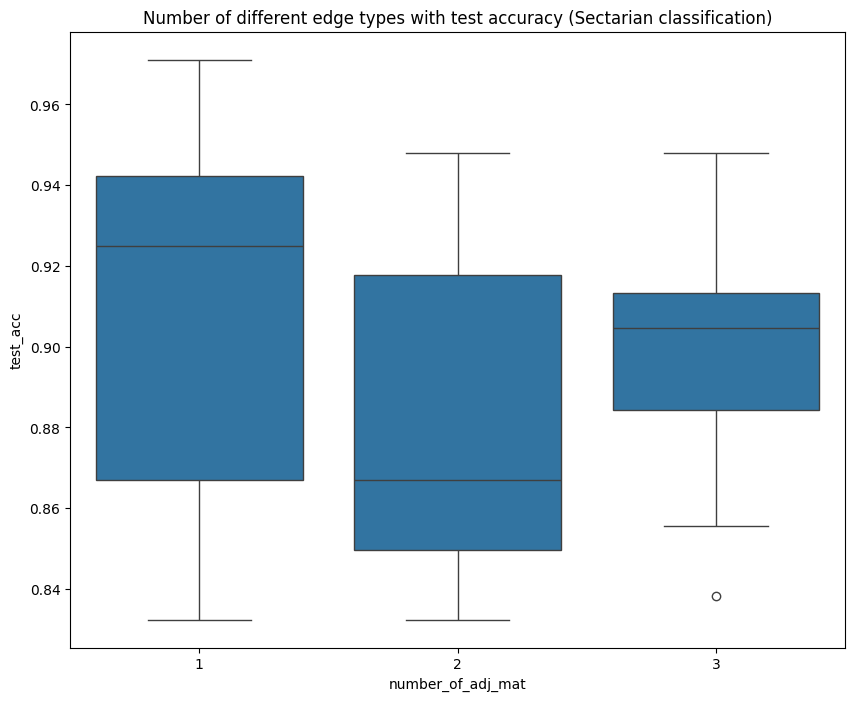

In [18]:
fig= plt.figure(figsize=(10,8))
tmp = all_results_gnn[all_results_gnn['task']=="section"]


tmp["number_of_adj_mat"] =tmp["adj_type"].str.split("&").str.len()
sns.boxplot(data=tmp, x="number_of_adj_mat", y="test_acc")
plt.title("Number of different edge types with test accuracy (Sectarian classification)")

Text(0.5, 1.0, 'Number of different edge types with test accuracy (Sectarian classification)(removing topic modeling and starr)')

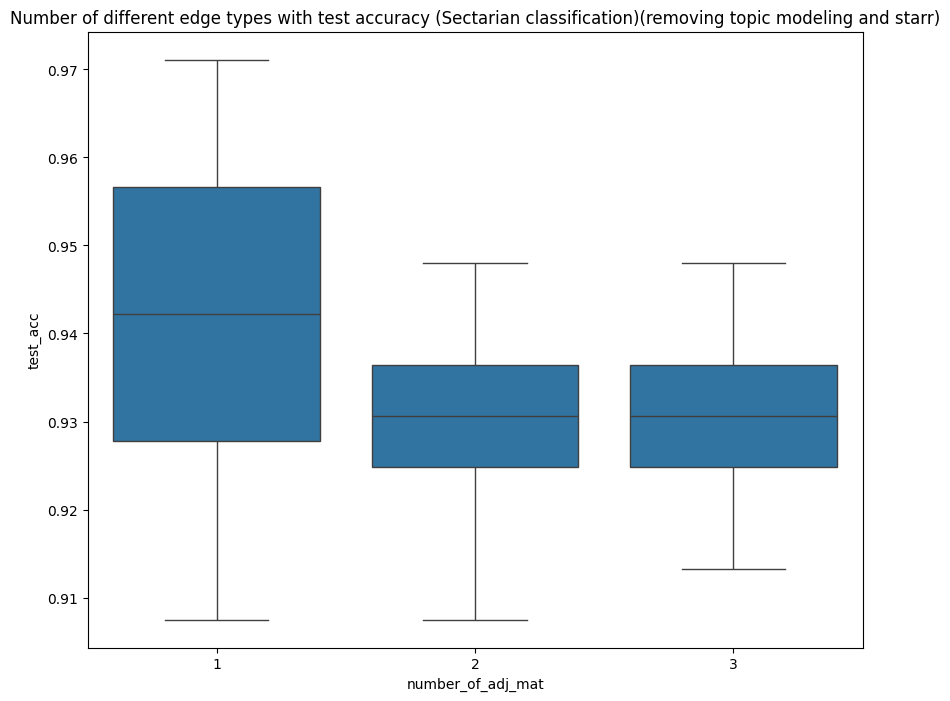

In [19]:
fig= plt.figure(figsize=(10,8))
tmp = all_results_gnn[all_results_gnn['task']=="section"]
tmp=tmp[(~tmp["adj_type"].str.contains("starr"))]
tmp = tmp[(~tmp["adj_type"].str.contains("topic"))]

tmp["number_of_adj_mat"] =tmp["adj_type"].str.split("&").str.len()
sns.boxplot(data=tmp, x="number_of_adj_mat", y="test_acc")
plt.title("Number of different edge types with test accuracy (Sectarian classification)(removing topic modeling and starr)")

In [222]:

tmp.groupby(["number_of_adj_mat"])["weighted_f1"].max()

number_of_adj_mat
1    0.971354
2    0.944338
3    0.945545
Name: weighted_f1, dtype: float64